### Introduction

Cryptocurrency markets are known for their inherent volatility and substantial trading volumes, operating continuously unlike traditional capital markets. This uninterrupted flow of data is immensely valuable for time series forecasting. However, the lack of underlying fundamental data for many cryptocurrencies means that price movements are primarily driven by technical indicators and market sentiment. This dynamic creates an environment where traders can potentially achieve significant gains, but also face substantial losses.

In this project, our aim is to analyze 14 cryptocurrencies and predict their short-term price movements. Utilizing a time-series API, we'll access historical data while ensuring we don't access any future information, maintaining integrity in our prediction process.

### Data

The training file, `train.csv`, contains the following columns:

- `timestamp`: Represents the minute covered by the row.
- `Asset_ID`: An identification code for the cryptoasset.
- `Count`: Indicates the number of trades that occurred during this minute.
- `Open`: Reflects the USD price at the beginning of the minute.
- `High`: Represents the highest USD price observed during the minute.
- `Low`: Indicates the lowest USD price observed during the minute.
- `Close`: Denotes the USD price at the end of the minute.
- `Volume`: Represents the number of units of the cryptoasset traded during the minute.
- `VWAP`: Represents the volume-weighted average price for the minute.
- `Target`: Reflects the 15-minute residualized returns.

In [21]:
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib

### Asset Data Exploration

In [6]:
assets_df = pd.read_csv("asset_details.csv")
assets_df.sort_values("Weight", ascending=False)

,Asset_ID,Weight,Asset_Name
2,1,6.779922,Bitcoin
5,6,5.894403,Ethereum
10,3,4.406719,Cardano
1,0,4.304065,Binance Coin
13,4,3.555348,Dogecoin
0,2,2.397895,Bitcoin Cash
6,9,2.397895,Litecoin
4,7,2.079442,Ethereum Classic
9,12,2.079442,Stellar
8,13,1.791759,TRON


We see that the top cryptocurrencies are included for this competition, such as Bitcoin, Ethereum, Binance Coin, etc. Additionally, there is a weights column provided, which will be utilized to calculate the weighted Pearson correlation coefficient evaluation metric.

Let's calculate the sum of the weights to verify if they add up to 100.

In [7]:
assets_df["Weight"].sum()

40.879847092769616

It appears that the weights add up to 40.88. However, the exact reason for this discrepancy is unclear. Let's proceed to calculate the percentage of weights assigned to each of the assets now.

In [8]:
assets_df["weight_percentage"] = (assets_df["Weight"] / assets_df["Weight"].sum()) * 100
assets_df.sort_values("Weight", ascending=False)

,Asset_ID,Weight,Asset_Name,weight_percentage
2,1,6.779922,Bitcoin,16.584998
5,6,5.894403,Ethereum,14.418848
10,3,4.406719,Cardano,10.779686
1,0,4.304065,Binance Coin,10.528574
13,4,3.555348,Dogecoin,8.697068
0,2,2.397895,Bitcoin Cash,5.865715
6,9,2.397895,Litecoin,5.865715
4,7,2.079442,Ethereum Classic,5.086716
9,12,2.079442,Stellar,5.086716
8,13,1.791759,TRON,4.382990


In [9]:
assets_df["weight_percentage"].sum()

99.99999999999999

The weight percentages now add up to 100 when we calculated for weights assigned to each of the assets. We can now visualize this. 

In [13]:
fig = px.pie(assets_df, values='weight_percentage', names='Asset_Name', title='Weights by cryptocurrency')
fig.show()

### Train Data Exploration

Now lets explore the training data.

In [14]:
crypto_df = pd.read_csv("train.csv")
print(f"There are {crypto_df.shape[0]} rows in the given dataset")
crypto_df.head()

There are 24236806 rows in the given dataset


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


#### Start and End time
Now lets look at the start and end time for each of the crypto currencies. 

In [15]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in assets_df.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

time_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    start_time = coin_df.index[0].astype('datetime64[s]')
    end_time = coin_df.index[-1].astype('datetime64[s]')
    time_list.append([coin, start_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Start_Time", "End_Time"]
time_df

,Asset_Name,Start_Time,End_Time
0,Bitcoin,2018-01-01 00:01:00,2021-09-21
1,Ethereum,2018-01-01 00:01:00,2021-09-21
2,Cardano,2018-04-17 09:11:00,2021-09-21
3,Binance Coin,2018-01-01 00:01:00,2021-09-21
4,Dogecoin,2019-04-12 14:34:00,2021-09-21
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-21
6,Litecoin,2018-01-01 00:01:00,2021-09-21
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-21
8,Stellar,2018-02-16 23:53:00,2021-09-21
9,TRON,2018-02-06 21:37:00,2021-09-21


By examining the start and end times of each cryptocurrency, we observe that the earliest recorded date in the dataset is January 1, 2018, which is the starting point for most coins. The data spans until September 21, 2021, with all coins sharing the same end timestamp. Notably, Dogecoin has the shortest historical data among the provided coins, with records available only from April 2019 onwards.

#### Missing data

Now we can check for missing data for each of the assets

In [16]:
missing_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist())
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']
missing_df

,Asset_Name,TotalRows,Missing_Asset_ID,Missing_Count,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume,Missing_VWAP,Missing_Target
0,Bitcoin,1956282,0,0,0,0,0,0,0,0,304
1,Ethereum,1956200,0,0,0,0,0,0,0,0,340
2,Cardano,1791867,0,0,0,0,0,0,0,0,18731
3,Binance Coin,1942619,0,0,0,0,0,0,0,0,13415
4,Dogecoin,1156866,0,0,0,0,0,0,0,0,144974
5,Bitcoin Cash,1953537,0,0,0,0,0,0,0,0,4861
6,Litecoin,1956030,0,0,0,0,0,0,0,0,521
7,Ethereum Classic,1951127,0,0,0,0,0,0,0,0,9326
8,Stellar,1778749,0,0,0,0,0,0,0,0,61816
9,TRON,1874560,0,0,0,0,0,0,0,0,21014


Upon analyzing the missing data, it becomes evident that the Target column exhibits numerous gaps. Conversely, the remaining columns are devoid of any missing data. Bitcoin displays the fewest missing target values, while Monero demonstrates the highest count. It's imperative to handle these missing target values with caution and diligence.

#### Gaps

We can see from above that there are numerous gaps. For a given minute, the absence of NaN values indicates missing data, represented by the absence of those rows. Thus, we need to examine the data gaps.

Since the data is collected every 60 seconds, a gap of more than one minute between consecutive rows suggests missing data in between. We'll assess this for each cryptocurrency.

In [17]:
gap_list = []
for coin in asset_names:
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index()
    n_gaps = gap_df[gap_df["index"]!=60]["timestamp"].sum()
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df

,Asset_Name,number_of_gaps,max_gap_in_seconds
0,Bitcoin,145,2400
1,Ethereum,156,7200
2,Cardano,9360,4800
3,Binance Coin,6600,120720
4,Dogecoin,76652,7260
5,Bitcoin Cash,2502,4380
6,Litecoin,291,5280
7,Ethereum Classic,4707,3780
8,Stellar,37770,8520
9,TRON,12225,3000


The dataset contains multiple gaps that require careful handling. The Maker coin exhibits the largest gap, spanning 281,700 seconds or approximately 78 hours.

When encountering gaps in the data, computing returns for the subsequent time periods becomes challenging. This could be a contributing factor to the presence of missing target values in our dataset.

#### Visualization

Let's proceed to visualize the training data and observe how the prices of the coins have fluctuated over time.

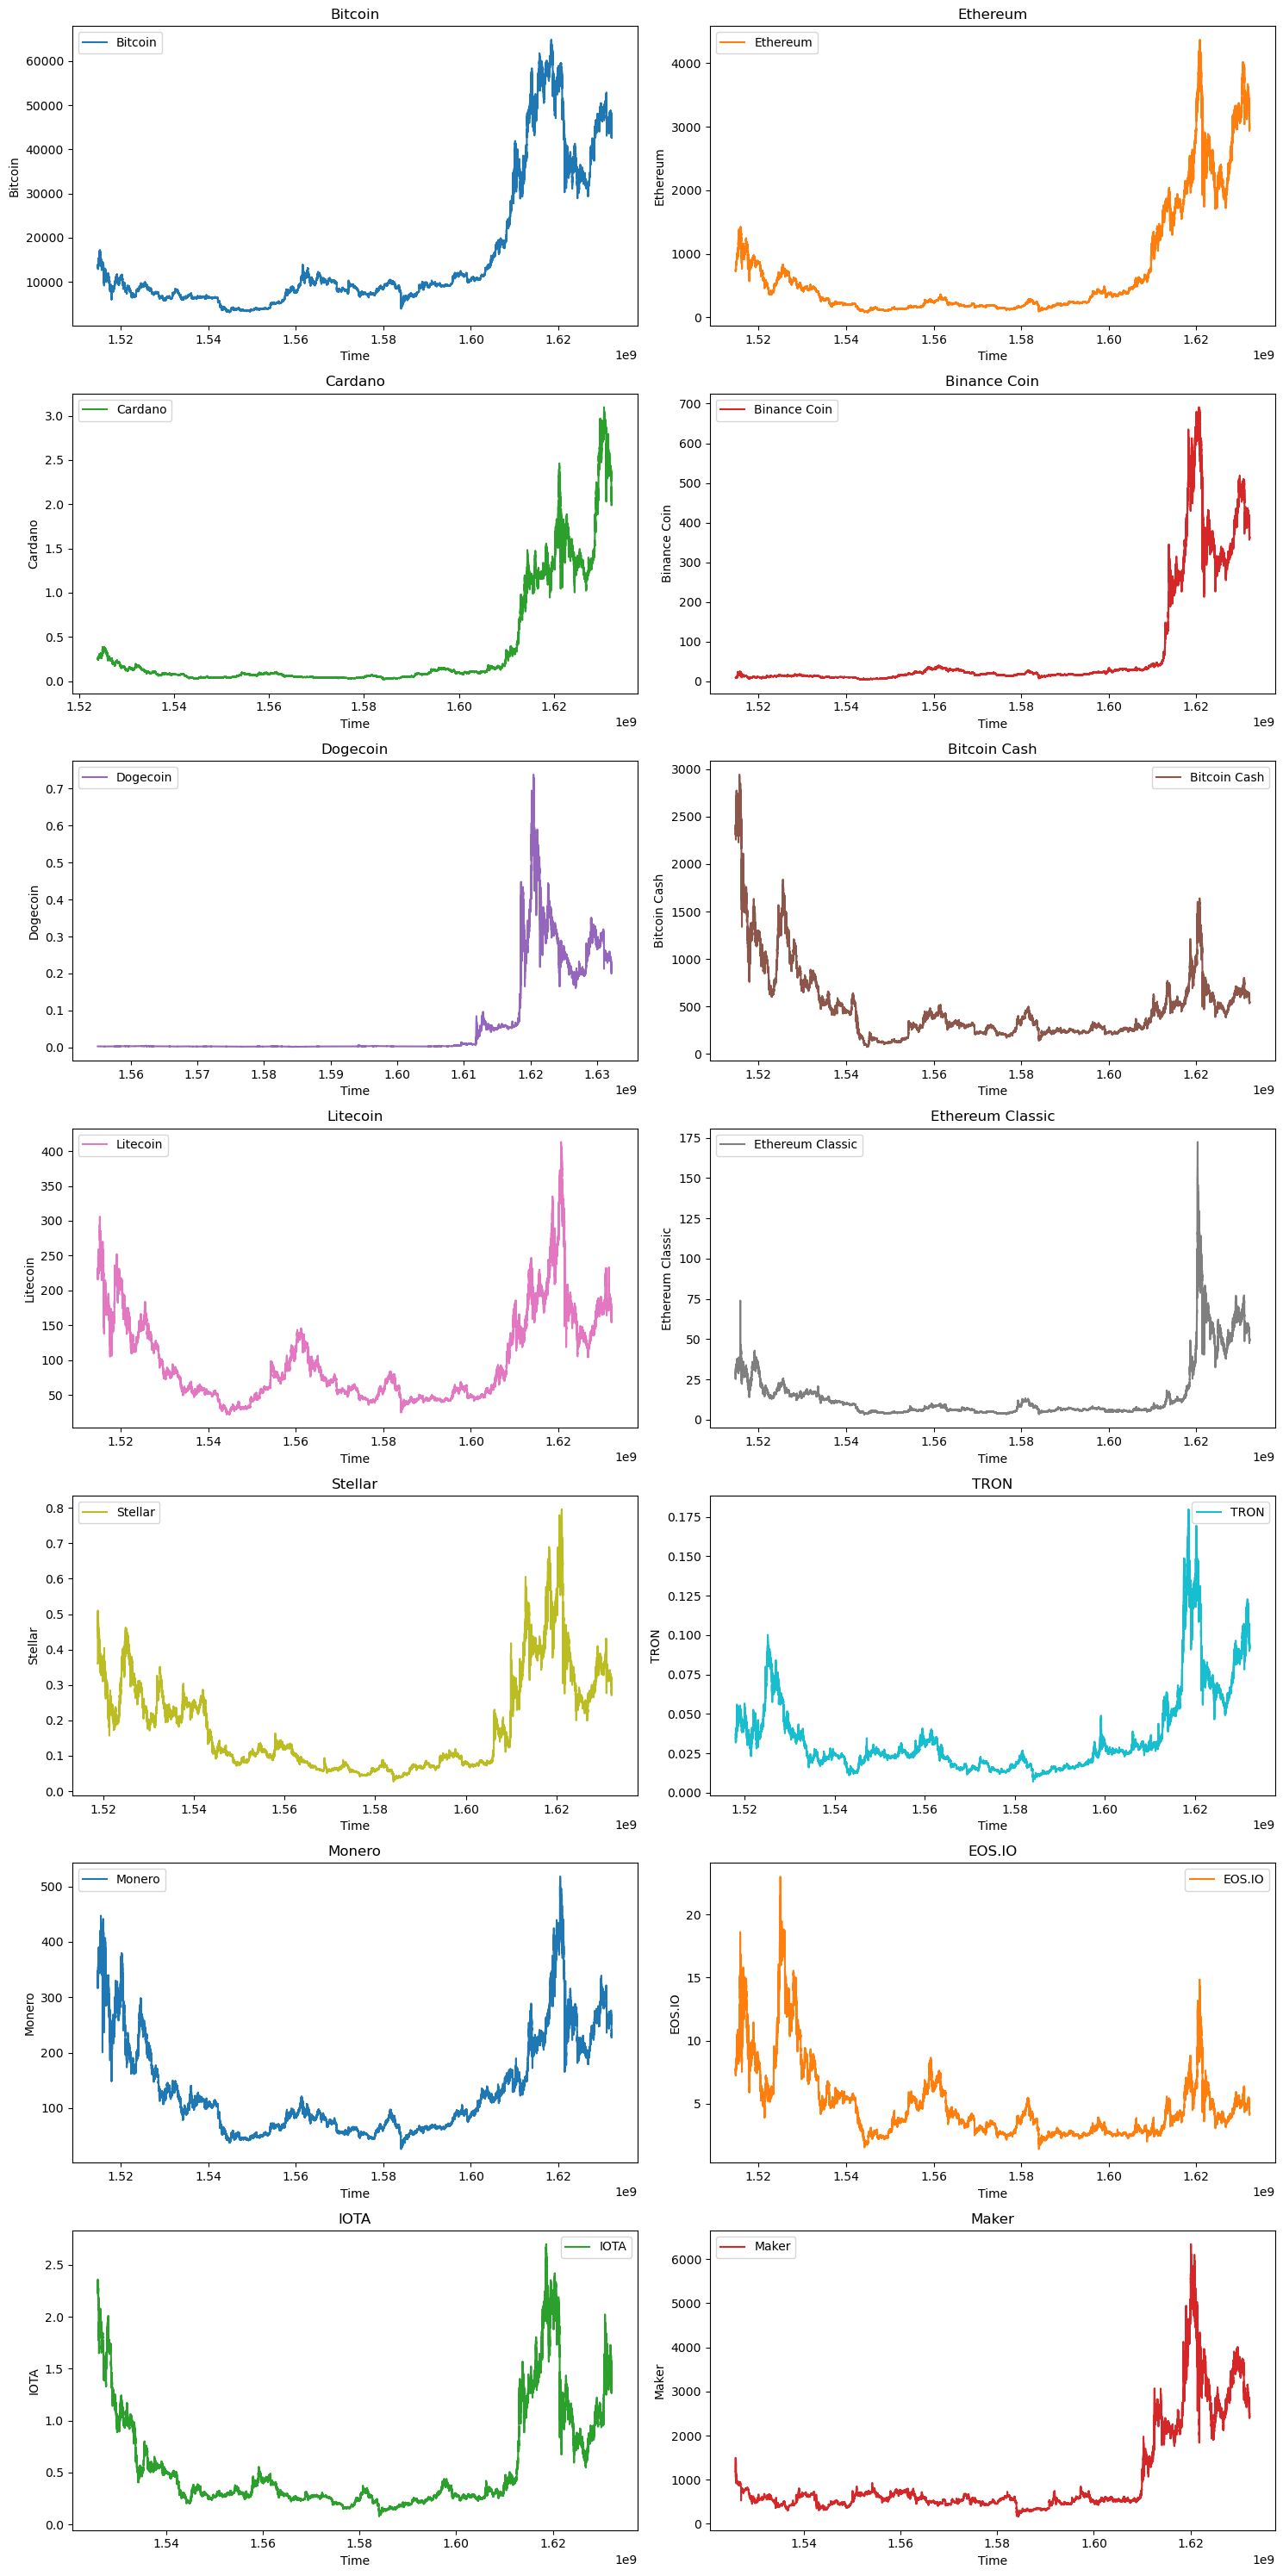

In [23]:
import matplotlib.pyplot as plt

# Define a colormap for distinguishing between different coins
cmap = plt.get_cmap('tab10')

# Plot close values as time series for all the assets
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = crypto_df[crypto_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # Fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60), method='pad')
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap(ind%10))
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

### Correlation


